In [4]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:

import pickle
with open('data/pickle_files/final_dataframe.pkl', 'rb') as file:
    df = pickle.load(file)

In [3]:
df

,CTSH,correlation,SIRI
2024-02-26 09:45:00,78.93,NaN,4.5735
2024-02-26 09:46:00,78.93,NaN,4.5735
2024-02-26 09:47:00,78.93,NaN,4.5735
2024-02-26 09:48:00,78.93,NaN,4.5735
2024-02-26 09:49:00,78.93,NaN,4.5735
...,...,...,...
2024-04-08 15:34:00,67.83,1.0,3.1800
2024-04-08 15:24:00,67.83,1.0,3.1800
2024-04-08 15:21:00,67.83,1.0,3.1800
2024-02-26 15:27:00,67.83,1.0,3.1800


In [4]:


def prepare_lstm_data(df, input_sequence_length=60, batch_size=32, split_fraction=0.7):
    """
    Prepare data for an LSTM model using stock_1 and correlation as features,
    and stock_2 as the target.

    Args:
        df (DataFrame): Input DataFrame with columns ['AdjClose_Stock_1', 'AdjClose_Stock_2', 'Rolling_Correlation_Coefficient'].
        input_sequence_length (int): Number of past time steps to use as input.
        batch_size (int): Batch size for the TimeseriesGenerator.
        split_fraction (float): Fraction of data to use for training.

    Returns:
        train_dataset (TimeseriesGenerator): Training data generator.
        test_dataset (TimeseriesGenerator): Testing data generator.
        scaler_features (StandardScaler): Scaler used for normalizing the input features.
        scaler_target (StandardScaler): Scaler used for normalizing the target values.
    """
    # Ensure required columns are present in the DataFrame
    required_columns = ['CTSH', 'SIRI', 'correlation']
    for col in required_columns:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")

    # Extract the columns
    stock_1 = df['CTSH'].values.reshape(-1, 1)
    stock_2 = df['SIRI'].values.reshape(-1, 1)  # Target variable
    correlation = df['correlation'].values.reshape(-1, 1)

    # Normalize the features (stock_1 and correlation) and the target (stock_2)
    scaler_features = StandardScaler()
    scaler_target = StandardScaler()

    # Stack features (stock_1 and correlation) together and normalize
    features = np.hstack([stock_1, correlation])
    normalized_features = scaler_features.fit_transform(features)

    # Normalize the target (stock_2)
    normalized_target = scaler_target.fit_transform(stock_2)

    # Split the data into training and test sets
    num_samples = len(df)
    train_size = int(split_fraction * num_samples)

    # Create TimeseriesGenerator instances for train and test sets
    train_dataset = TimeseriesGenerator(
        data=normalized_features[:train_size],
        targets=normalized_target[:train_size],
        length=input_sequence_length,
        batch_size=batch_size,
    )

    test_dataset = TimeseriesGenerator(
        data=normalized_features[train_size:],
        targets=normalized_target[train_size:],
        length=input_sequence_length,
        batch_size=batch_size,
    )

    return train_dataset, test_dataset, scaler_features, scaler_target


In [5]:

def lstm_model(train_dataset, scaler):
    """
    Builds, trains, and prepares an LSTM model using the training data.

    Parameters:
        train_dataset: TimeseriesGenerator providing the input and target data.
        scaler: StandardScaler used for normalizing the target data.

    Returns:
        model (Sequential): Trained LSTM model.
        inverse_transform_predictions (function): Function to inverse transform predictions.
    """
    # Infer input shape from the TimeseriesGenerator
    input_shape = train_dataset[0][0].shape[1:]  # (sequence_length, number_of_features)

    # Build the LSTM model
    model = Sequential()
    # 1st Layer
    model.add(LSTM(units=64, activation='relu', return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))  # Increased dropout to avoid overfitting
    # 2nd Layer
    model.add(LSTM(units=64, activation='relu', return_sequences=False))
    model.add(Dropout(0.3))

    # Output Layer
    model.add(Dense(units=1))  # Single output value

    # Compile the model with a lower learning rate
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Define EarlyStopping callback
    early_stopping = EarlyStopping(
        monitor='loss',  # Monitor training loss
        patience=3,  # Stop training after 3 epochs with no improvement
        restore_best_weights=True  # Restore the best weights after stopping
    )

    # Train the model using the TimeseriesGenerator
    model.fit(train_dataset, epochs=20, callbacks=[early_stopping], verbose=1)

    # Define a helper function for inverse transformation
    def inverse_transform_predictions(predictions):
        return scaler.inverse_transform(predictions.reshape(-1, 1))

    return model, inverse_transform_predictions


In [6]:


def evaluate_and_plot(model, test_dataset, inverse_transform, scaler_target):
    """
    Make predictions, compute metrics, and plot the predicted vs. actual values.
    
    Parameters:
        model: Trained LSTM model.
        test_dataset: TimeseriesGenerator providing the test data.
        inverse_transform: Function to inverse-transform predictions.
        scaler_target: StandardScaler used for normalizing the target data.
        
    Returns:
        None
    """
    # Get the true target values and model predictions
    actuals = []
    predictions = []
    
    for i in range(len(test_dataset)):
        x_batch, y_batch = test_dataset[i]
        pred_batch = model.predict(x_batch, verbose=0)
        predictions.append(pred_batch)
        actuals.append(y_batch)
    
    # Concatenate all batches
    predictions = np.vstack(predictions)
    actuals = np.vstack(actuals)

    # Inverse transform to get values back to the original scale
    predictions_original = inverse_transform(predictions)
    actuals_original = scaler_target.inverse_transform(actuals)

    # Compute metrics
    mse = mean_squared_error(actuals_original, predictions_original)
    mae = mean_absolute_error(actuals_original, predictions_original)
    r2 = r2_score(actuals_original, predictions_original)

    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-Squared (R²): {r2:.4f}")

    # Plot actual vs predicted
    plt.figure(figsize=(12, 6))
    plt.plot(actuals_original, label="Actual Stock 2 Prices", color='blue')
    plt.plot(predictions_original, label="Predicted Stock 2 Prices", color='orange', linestyle='dashed')
    plt.title("Actual vs Predicted Stock 2 Prices")
    plt.xlabel("Time Steps")
    plt.ylabel("Stock 2 Price")
    plt.legend()
    plt.show()


In [7]:
df.info

<bound method DataFrame.info of                       CTSH  correlation    SIRI
2024-02-26 09:45:00  78.93          NaN  4.5735
2024-02-26 09:46:00  78.93          NaN  4.5735
2024-02-26 09:47:00  78.93          NaN  4.5735
2024-02-26 09:48:00  78.93          NaN  4.5735
2024-02-26 09:49:00  78.93          NaN  4.5735
...                    ...          ...     ...
2024-04-08 15:34:00  67.83          1.0  3.1800
2024-04-08 15:24:00  67.83          1.0  3.1800
2024-04-08 15:21:00  67.83          1.0  3.1800
2024-02-26 15:27:00  67.83          1.0  3.1800
2024-02-26 15:25:00  67.83          1.0  3.1800

[17432 rows x 3 columns]>

In [6]:

print(df.isna().sum())  # Check missing values per column
print(df[~df.applymap(np.isfinite)].count())  # Check infinite values

df.fillna(0, inplace=True)  # Replace NaN values with zero
df.replace([np.inf, -np.inf], 0, inplace=True)  # Replace infinite values with zero


print(df.isna().sum())  # Check missing values per column
print(df[~df.applymap(np.isfinite)].count())  # Check infinite values

CTSH             0
correlation    331
SIRI             0
dtype: int64
CTSH             0
correlation    320
SIRI             0
dtype: int64
CTSH           0
correlation    0
SIRI           0
dtype: int64
CTSH           0
correlation    0
SIRI           0
dtype: int64


C:\Users\giuli\AppData\Local\Temp\ipykernel_12312\1746365459.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(df[~df.applymap(np.isfinite)].count())  # Check infinite values
C:\Users\giuli\AppData\Local\Temp\ipykernel_12312\1746365459.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(df[~df.applymap(np.isfinite)].count())  # Check infinite values


In [17]:
# Step 1: Prepare Data
train_dataset, test_dataset, scaler_features, scaler_target = prepare_lstm_data(
    df, input_sequence_length=60, batch_size=32, split_fraction=0.7
)



In [18]:
# Step 2: Build and Train Model
model, inverse_transform = lstm_model(train_dataset, scaler_target)


Epoch 1/20


c:\Users\giuli\Repositories\nasdaq_causal-analysis_lstm\venv_12\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\giuli\Repositories\nasdaq_causal-analysis_lstm\venv_12\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


380/380 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - loss: 0.6142
Epoch 2/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - loss: 0.0986
Epoch 3/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - loss: 0.0822
Epoch 4/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - loss: 0.0716
Epoch 5/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - loss: 0.0721
Epoch 6/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - loss: 0.0634
Epoch 7/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - loss: 0.0636
Epoch 8/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 17s 43ms/step - loss: 0.0624
Epoch 9/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - loss: 0.0641
Epoch 10/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - loss: 0.0573
Epoch 11/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - loss: 0.0655
Epoch 12/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - loss: 0.0591
Epoch 13/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step - loss: 0.0522
Epoch 14/20
380/380 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - loss: 0.0503
Epoch 15/20
380/380 ━━━━━━━━━━━━━━━━━━━━

In [ ]:


# Save the model using pickle
def save_model_with_pickle(model, filename):
    # Serialize the model architecture and weights separately
    model_json = model.to_json()  # Convert model architecture to JSON
    model_weights = model.get_weights()  # Get model weights

    # Save the model architecture and weights to a pickle file
    with open(filename, 'wb') as f:
        pickle.dump({'model_json': model_json, 'model_weights': model_weights}, f)

# Example usage:
save_model_with_pickle(model, 'lstm_model_250425.pkl')


Mean Squared Error (MSE): 0.0102
Mean Absolute Error (MAE): 0.0580
R-Squared (R²): 0.9444


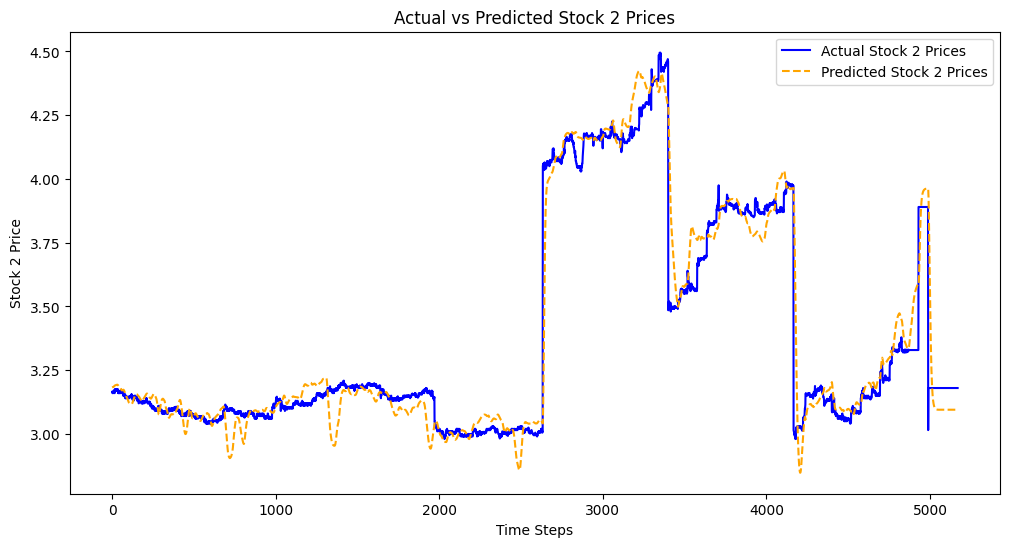

In [19]:

# Step 3: Evaluate and Plot
evaluate_and_plot(model, test_dataset, inverse_transform, scaler_target)